In [943]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, FunctionTransformer, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from models.prepareData import getData, convertData, calcMinimumMaximum
from models.models import linearRegressionModel, PolynomialFeatures, polynomialRegression

In [944]:
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Thọ', 'Phước Kiển', 'Nhà Bè')
# data = getData('Bán căn hộ chung cư', 'Nguyễn Hữu Cảnh', '22', 'Bình Thạnh')
data = getData('Bán đất', 'Trần Văn Giàu', 'Lê Minh Xuân', 'Bình Chánh')
# data = getData('Bán đất', 'Vườn Lài', 'An Phú Đông', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán nhà riêng', 'Phạm Văn Chiêu', '9', 'Gò Vấp')
# data = getData('Bán nhà riêng', 'Nguyễn Văn Quá', 'Đông Hưng Thuận', '12')
# data = getData('Bán nhà riêng', 'Quốc Lộ 13', 'Hiệp Bình Phước', 'Thủ Đức')
# data = getData('Bán đất', 'Nguyễn Thị Rành', 'Nhuận Đức', 'Củ Chi')

In [945]:
print("Data length: ", len(data))

Data length:  227


In [946]:
# preprocess data:

# sort data in post_date order to drop old data has same area:
data = data.sort_values(by=['posted_date'])

# Drop duplicates:    
data = data.drop_duplicates(subset='area', keep='last', inplace=False)

# sort data in area order:
data = data.sort_values(by=['area'])

In [947]:
print("Data length: ", len(data))

Data length:  33


In [948]:
# remove outliers using box-plot:
while True:
    area_minimum, area_maximum = calcMinimumMaximum(data['area'])
    if (data['area'] > area_minimum).all() and (data['area'] < area_maximum).all():
        break
    else:
        data = data[(data['area'] > area_minimum) & (data['area'] < area_maximum)]

while True:
    price_minimum, price_maximum = calcMinimumMaximum(data['price'])
    if (data['price'] > price_minimum).all() and (data['price'] < price_maximum).all():
        break
    else:
        data = data[(data['price'] > price_minimum) & (data['price'] < price_maximum)]

In [949]:
print("Train data length: ", len(data))

Train data length:  26


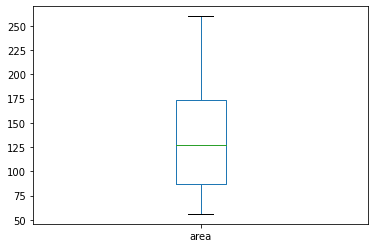

In [950]:
data['area'].plot(kind='box')
plt.show()

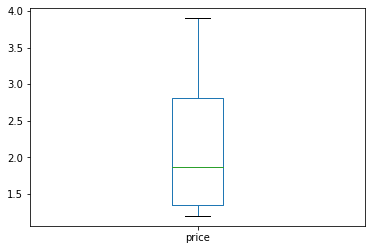

In [951]:
data['price'].plot(kind='box')
plt.show()

In [952]:
data

,post_type,area,price,street,ward,district,posted_date
121,Bán đất,56.0,1.19840,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-05-02
8,Bán đất,75.0,1.40000,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-03-19
153,Bán đất,80.0,1.20000,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-05-21
106,Bán đất,81.0,1.22000,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-04-23
180,Bán đất,84.0,1.30000,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-04-16
144,Bán đất,85.0,1.27500,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-05-13
212,Bán đất,86.0,1.30000,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-04-16
118,Bán đất,90.0,1.35000,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-05-01
127,Bán đất,100.0,1.50000,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-05-07
136,Bán đất,105.0,1.60000,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-05-12


In [953]:
data['price'].describe()

count    26.000000
mean      2.134323
std       0.887588
min       1.198400
25%       1.350000
50%       1.862500
75%       2.812500
max       3.900000
Name: price, dtype: float64

In [954]:
data['area'].describe()

count     26.000000
mean     135.830769
std       54.560548
min       56.000000
25%       87.000000
50%      127.500000
75%      173.250000
max      260.000000
Name: area, dtype: float64

In [955]:
area_mean = np.mean(data['area'])
area_std = np.std(data['area'])

price_mean = np.mean(data['price'])
price_std = np.std(data['price'])

data = data[~( (data['area'] < area_mean) & (data['price'] > price_mean) )]
data = data[~( (data['area'] > area_mean) & (data['price'] < price_mean - price_std) )]

In [956]:
data[(data['area'] <= 100.00) & (data['area'] >= 80.00)]

,post_type,area,price,street,ward,district,posted_date
153,Bán đất,80.0,1.200,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-05-21
106,Bán đất,81.0,1.220,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-04-23
180,Bán đất,84.0,1.300,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-04-16
144,Bán đất,85.0,1.275,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-05-13
212,Bán đất,86.0,1.300,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-04-16
118,Bán đất,90.0,1.350,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-05-01
127,Bán đất,100.0,1.500,Trần Văn Giàu,Lê Minh Xuân,Bình Chánh,2021-05-07


In [957]:
print("Data length: ", len(data))

Data length:  26


In [958]:
# divide data into train and test:
train_data, test_data = train_test_split(data, test_size=0.4)
test_data, validate_data = train_test_split(test_data, test_size=0.5)

In [959]:
# Sort data by area column:
train_data = train_data.sort_values(by=['area'])
test_data = test_data.sort_values(by=['area'])
validate_data = validate_data.sort_values(by=['area'])

print("\nTrain data length: ", len(train_data))
print("Test data length: ", len(test_data))
print("Validate data length: ", len(validate_data))


Train data length:  15
Test data length:  5
Validate data length:  6


In [960]:
# # convert data into numpy
X, Y = convertData(data)
X_train, Y_train = convertData(train_data)
X_test, Y_test = convertData(test_data)
X_validate, Y_validate = convertData(validate_data)

In [961]:
# scale data:

# Standard Scaler:

# X = StandardScaler().fit_transform(X)
# Y = StandardScaler().fit_transform(Y)

# X_train = StandardScaler().fit_transform(X_train)
# Y_train = StandardScaler().fit_transform(Y_train)

# X_test = StandardScaler().fit_transform(X_test)
# Y_test = StandardScaler().fit_transform(Y_test)

# X_validate = StandardScaler().fit_transform(X_validate)
# Y_validate = StandardScaler().fit_transform(Y_validate)


# Quantile Transformer:

# X = QuantileTransformer(n_quantiles=len(X_train), output_distribution='uniform').fit_transform(X)
# Y = QuantileTransformer(n_quantiles=len(Y_train), output_distribution='uniform').fit_transform(Y)

# X_train = QuantileTransformer(n_quantiles=len(X_train), output_distribution='uniform').fit_transform(X_train)
# Y_train = QuantileTransformer(n_quantiles=len(Y_train), output_distribution='uniform').fit_transform(Y_train)

# X_test = QuantileTransformer(n_quantiles=len(X_test), output_distribution='uniform').fit_transform(X_test)
# Y_test = QuantileTransformer(n_quantiles=len(X_test), output_distribution='uniform').fit_transform(Y_test)

# X_validate = QuantileTransformer(n_quantiles=len(X_validate), output_distribution='uniform').fit_transform(X_validate)
# Y_validate = QuantileTransformer(n_quantiles=len(Y_validate), output_distribution='uniform').fit_transform(Y_validate)

# Power Transformer:

# X = PowerTransformer(method='yeo-johnson').fit_transform(X)
# Y = PowerTransformer(method='yeo-johnson').fit_transform(Y)

# X_train = PowerTransformer(method='yeo-johnson').fit_transform(X_train)
# Y_train = PowerTransformer(method='yeo-johnson').fit_transform(Y_train)

# X_test = PowerTransformer(method='yeo-johnson').fit_transform(X_test)
# Y_test = PowerTransformer(method='yeo-johnson').fit_transform(Y_test)

# X_validate = PowerTransformer(method='yeo-johnson').fit_transform(X_validate)
# Y_validate = PowerTransformer(method='yeo-johnson').fit_transform(Y_validate)

# Log Transformer:

X = FunctionTransformer(np.log1p).fit_transform(X)
Y = FunctionTransformer(np.log1p).fit_transform(Y)

X_train = FunctionTransformer(np.log1p).fit_transform(X_train)
Y_train = FunctionTransformer(np.log1p).fit_transform(Y_train)

X_test = FunctionTransformer(np.log1p).fit_transform(X_test)
Y_test = FunctionTransformer(np.log1p).fit_transform(Y_test)

X_validate = FunctionTransformer(np.log1p).fit_transform(X_validate)
Y_validate = FunctionTransformer(np.log1p).fit_transform(Y_validate)

In [962]:
# # Local Outlier Factor:
# from sklearn.neighbors import LocalOutlierFactor

# lof = LocalOutlierFactor()
# yhat = lof.fit_predict(X_train)
# mask = yhat != -1
# X_train, Y_train = X_train[mask, :], Y_train[mask]

Text(0.5, 1.0, 'Y_validate')

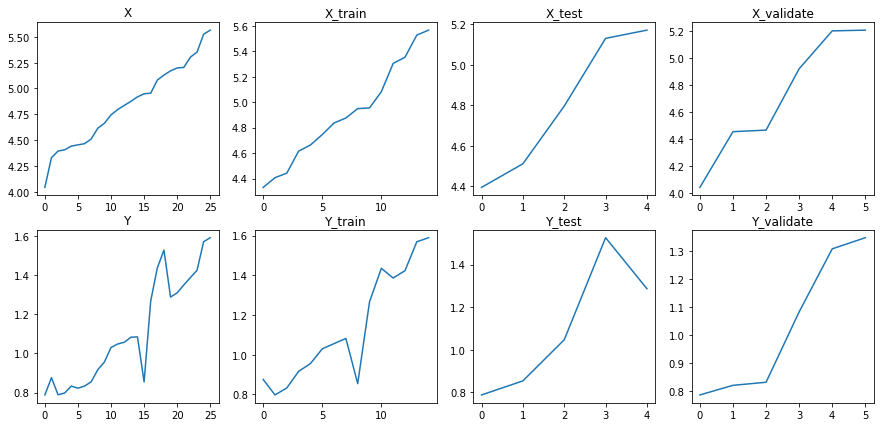

In [963]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7))
ax[0][0].plot(X)
ax[0][0].set_title('X')
ax[0][1].plot(X_train)
ax[0][1].set_title('X_train')
ax[0][2].plot(X_test)
ax[0][2].set_title('X_test')
ax[0][3].plot(X_validate)
ax[0][3].set_title('X_validate')

ax[1][0].plot(Y)
ax[1][0].set_title('Y')
ax[1][1].plot(Y_train)
ax[1][1].set_title('Y_train')
ax[1][2].plot(Y_test)
ax[1][2].set_title('Y_test')
ax[1][3].plot(Y_validate)
ax[1][3].set_title('Y_validate')

In [964]:
# find model by using linear regression:
linear_model = linearRegressionModel(X_train, Y_train)

# find Y by using linear model predict:
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)

# Calculate RMSE on train and test data:
train_linear_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
test_linear_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))


Linear Regression Model: 


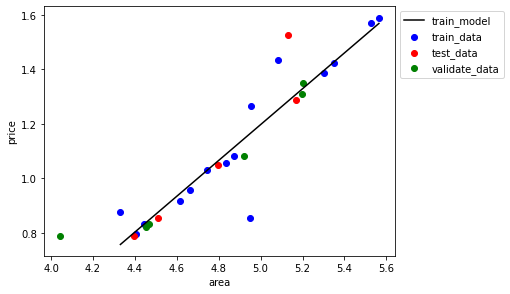

In [965]:
print("\nLinear Regression Model: ")
# Plot linear model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [966]:
# Linear Model coefficient and intercept:
print("Linear model coefficient: {}".format(linear_model.coef_))
print("Linear model intercept: {}".format(linear_model.intercept_))

# linear_model rmse:
print("Linear model rmse on train data: {}".format(train_linear_rmse))
print("Linear model rmse on test data: {}".format(test_linear_rmse))
print("\n\n")

Linear model coefficient: [[0.65718878]]
Linear model intercept: [-2.08867294]
Linear model rmse on train data: 0.1026809484720385
Linear model rmse on test data: 0.11008831984992905





In [967]:
# find model by using polynomial regression:
poly_model, degree, train_rmse, validate_rmse, test_rmse = polynomialRegression(X, Y, X_train, Y_train, X_test, Y_test, X_validate, Y_validate)

# transform X and X_test:
polynomial_features = PolynomialFeatures(degree=degree)
X_train_poly = polynomial_features.fit_transform(X_train)
X_test_poly = polynomial_features.fit_transform(X_test)

# Try predicting Y
Y_train_poly_pred = poly_model.predict(X_train_poly)
Y_test_poly_pred = poly_model.predict(X_test_poly)


Selected Polynomial Regression with degree = 5 and validate RMSE = 0.0285792025209071


D:\Software\Miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011799630674466863, tolerance: 0.0010991917739653302
  model = cd_fast.enet_coordinate_descent(
D:\Software\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
D:\Software\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
D:\Software\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
D:\Software\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:682: Undefined

Selected Regularized Regression with alpha = 1e-05 and validate RMSE = 0.051755976924059414
Polynomial Regression cross validation score:  -4.248768887036825
Selected Regularized Regression cross validation score:  -4.244656936274129


D:\Software\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
D:\Software\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
D:\Software\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
D:\Software\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
D:\Software\Miniconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, Unde

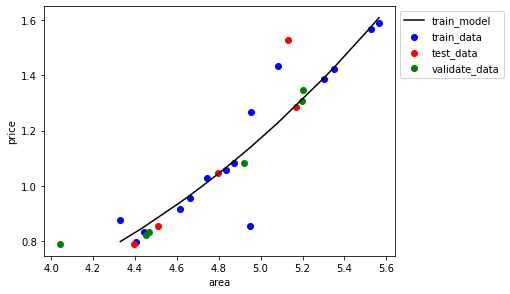

In [968]:
# Plot model:
plt.figure(figsize=(7, 4))
plt.scatter(X_train, Y_train, marker='o', color='blue', label='train_data')
plt.scatter(X_test, Y_test, marker='o', color='red', label='test_data')
plt.scatter(X_validate, Y_validate, marker='o', color='green', label='validate_data')
plt.plot(X_train, Y_train_poly_pred, color='black', label='train_model')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.xlabel('area')
plt.ylabel('price')
plt.show()

In [969]:
print("Polynomial Regression with degree = {}\n".format(degree))
# Polynomial Model coefficient and intercept:
print("Polynomial model coefficient:")
print(poly_model.coef_)
print("Polynomial model intercept: {}\n".format(poly_model.intercept_))

# poly_model rmse:
print("Polynomial Model RMSE on train data: {}".format(train_rmse))
print("Polynomial Model RMSE on validate data: {}".format(validate_rmse))
print("Polynomial Model RMSE on test data: {}".format(test_rmse))

Polynomial Regression with degree = 5

Polynomial model coefficient:
[ 0.00000000e+00 -1.79456993e-01  2.10081511e-02  5.28057566e-03
  4.18973820e-04  1.03409111e-05]
Polynomial model intercept: [0.58953195]

Polynomial Model RMSE on train data: 0.09944310966760825
Polynomial Model RMSE on validate data: 0.051755976924059414
Polynomial Model RMSE on test data: 0.12042044743747166


In [970]:
# score the model with test data:

# Linear score:
print("\n")
print("Linear Model score on train dataset: ", linear_model.score(X_train, Y_train))
print("Linear Model score on test dataset: ", linear_model.score(X_test, Y_test))

# Poly score:
print("\n")
print("Poly Model score on train dataset: ", poly_model.score(X_train_poly, Y_train))
print("Poly Model score on test dataset: ", poly_model.score(X_test_poly, Y_test))



Linear Model score on train dataset:  0.8561209595699271
Linear Model score on test dataset:  0.839026055978987


Poly Model score on train dataset:  0.8650517731129436
Poly Model score on test dataset:  0.8073923330648941


In [971]:
# calc cross validation score of linear to compare with poly for best model selection
linear_cv = np.mean(cross_val_score(linear_model, X, Y, cv=5))
poly_cv = np.mean(cross_val_score(poly_model, X, Y, cv=5))
best_model = linear_model if linear_cv > poly_cv else poly_model
best_degree = 1 if linear_cv > poly_cv else degree

print(linear_cv)
print(poly_cv)

-4.248768887036825
-4.244656936274129


In [972]:
import unidecode
street = unidecode.unidecode(data['street'].iloc[0].lower().replace(" ", ""))
ward = unidecode.unidecode(data['ward'].iloc[0].lower().replace(" ", ""))
district = unidecode.unidecode(data['district'].iloc[0].lower().replace(" ", ""))
model_name = street + "_" + ward + "_" + district

In [973]:
# Save model after training for later use:
from joblib import dump, load

dump((best_model, best_degree), 'trained/' + model_name + ".joblib")

['trained/tranvangiau_leminhxuan_binhchanh.joblib']

In [974]:
# load model:
loaded_model, loaded_degree = load('trained/' + model_name + ".joblib")

test_area = np.array([92.00])
test_area = test_area[:, np.newaxis]
test_area = FunctionTransformer(np.log1p).fit_transform(test_area)

if loaded_degree == 1:
    predicted_price = loaded_model.predict(test_area)
else:
    test_area_poly = PolynomialFeatures(degree=loaded_degree).fit_transform(test_area)
    predicted_price = loaded_model.predict(test_area_poly)
    
FunctionTransformer(np.log1p).inverse_transform(predicted_price)

array([0.89607394])